# Support vector machines soft margin

 - Informações sobre o conjunto de dados
    1. variance of Wavelet Transformed image (continuous)
    2. skewness of Wavelet Transformed image (continuous)
    3. curtosis of Wavelet Transformed image (continuous)
    4. entropy of image (continuous)
    5. class (integer)




In [169]:
import sys 

sys.path.append("/home/davi/PycharmProjects/Reconhecimento-de-Padroes")

from sklearn.model_selection import KFold
from Strings import string
from sklearn.model_selection import train_test_split
from numpy import zeros, identity, array, concatenate, \
    ones, ravel, dot, where, mean
from src.Utils.utils import get_accuracy, get_data
import matplotlib.pyplot as plt
from pandas import DataFrame
import cvxopt
import cvxopt.solvers


In [170]:
def get_p(number_lines, number_columns):
    tmp_aux = identity(number_columns)
    tmp_aux[:, number_columns-1] = 0
    
    print(tmp_aux.shape)
    P = cvxopt.matrix(tmp_aux, tc='d')
    return P

In [171]:
def get_q(number_columns):
    tmp1 = zeros((number_columns, 1))
    print(tmp1.shape)
    Q = cvxopt.matrix(tmp1, tc='d')
    
    return Q

In [172]:
def get_g(x, y, number_lines):
    if array(y, ndmin=2).shape[0] == 1: 
        tmp2 = array(y, ndmin=2).T * concatenate((x, ones((number_lines, 1))), axis=1)
    else:
        tmp2 = array(y, ndmin=2) * concatenate((x, ones((number_lines, 1))), axis=1)


    # print(tmp2.shape)
    # G = cvxopt.matrix(tmp2 * -1., tc='d')
    # return G
    
    # tmp2 = array(y, ndmin=2).T * concatenate((x, ones((number_lines, 1))), axis=1)
    print(tmp2.shape)
    G = cvxopt.matrix((tmp2 * -1.).T.tolist())

    return G

In [173]:
def get_h(number_lines):
    tmp2 = ones((number_lines, 1))
    
    print(tmp2.shape)
    H = cvxopt.matrix(tmp2 * -1., tc='d')

    return H

In [174]:
def quadratic_solver(x_train, y_train):
    
    number_lines, number_columns = x_train.shape 
    
    # bias
    number_columns += 1
    
    P = get_p(number_lines, number_columns)
    Q = get_q(number_columns)
    G = get_g(x_train, y_train, number_lines)
    H = get_h(number_lines)
    
    

    try:
        solution = cvxopt.solvers.qp(P, Q, G, H)
        best_weights = ravel(solution['x'])  
        return best_weights
    
    except ValueError as error:
        print(error)



In [175]:
def train(x_train, y_train):
    solution = quadratic_solver(x_train, y_train)
    return solution

In [176]:
def get_foward(weights, x_test):
    
    print(weights)
    print(x_test.shape)
    
    if x_test.shape[1] == array(weights[:weights.shape[0]-1], ndmin=2).shape[1]:
        H_output = dot(x_test, array(weights[:weights.shape[0]-1], ndmin=2).T)

    else:
        H_output = dot(x_test, array(weights[:weights.shape[0] - 1], ndmin=2))

    H_output += weights[weights.shape[0]-1]
    
    # H_output = dot(x_test, array(weights[:2], ndmin=2).T) + weights[2]
    # vec_sup = sum(H_output == 1.)
    return H_output


In [177]:
def predict(h, domain=None):
    if domain == [-1., 1.]:
        for i in range(len(h)):
            if h[i][0] > 0:
                h[i][0] = 1
            else:
                h[i][0] = -1

        return h
    

In [178]:
def test(weights, x_test, y_test):
    h_output = get_foward(weights, x_test)
    y_output = predict(h_output, domain=[-1., 1.])

    if y_output.shape == y_test.T.shape:
        accuracy = get_accuracy(y_output, array(y_test, ndmin=2).T)
    else:
        accuracy = get_accuracy(y_output, array(y_test, ndmin=2))
    
    return accuracy

In [179]:
data = get_data("column_2C_weka.arff", type="arff")
data = DataFrame(data)
number_lines = data.shape[0]
number_columns = data.shape[1]
X = array(data, ndmin=2)[:, :number_columns-1]
Y =   array(array(data, ndmin=2)[:, number_columns-1], ndmin=2).T
train_size = .8
test_size = .2

indices = where(Y == b'Abnormal')
Y[indices] = -1

indices = where(Y == b'Normal')
Y[indices] = 1

# print(X)
# print(Y)

[100]
(7, 7)
(7, 1)
[[-32.09098679 -6.989378081 -35.99819848 ... -132.264735 -6.413427708
  -1.0]
 [45.25279209 8.693157364 41.5831264 ... 118.5458418 0.214750167 1.0]
 [46.23639915 10.0627701 37.0 ... 128.0636203 -5.100053328 1.0]
 ...
 [69.3988184 18.89840693 75.96636144 ... 103.5825398 -0.44366081 1.0]
 [36.15782981 -0.810514093 33.62731353 ... 135.9369096 -2.092506504 1.0]
 [-86.04127982 -38.75066978 -47.87140494 ... -122.0929536 -61.98827709
  -1.0]]
(248, 1)
     pcost       dcost       gap    pres   dres
 0:  5.4793e-04  4.1032e+02  1e+03  3e+00  3e+04
 1:  2.0376e-03  3.5885e+02  1e+03  2e+00  2e+04
 2:  1.1871e-03  1.0838e+03  1e+03  2e+00  2e+04
 3:  4.4756e-06  3.3683e+03  8e+02  1e+00  1e+04
 4:  1.4153e-06  1.0287e+04  1e+03  1e+00  1e+04
 5:  1.0942e-06  2.0034e+04  2e+03  1e+00  1e+04
 6:  1.6397e-07  1.7419e+05  3e+03  1e+00  1e+04
 7:  3.1398e-06  6.0381e+06  4e+04  1e+00  1e+04
 8:  4.8638e-02  7.5351e+08  7e+05  1e+00  1e+04
Terminated (singular KKT matrix).
[-1.8006

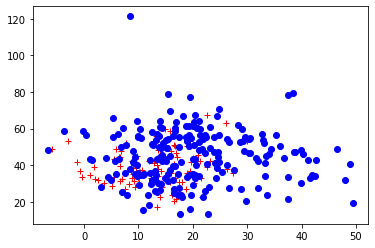

In [180]:
acc = []
pos = X[where(Y == 1)[0]]
neg = X[where(Y == -1)[0]]

print(sum(Y==1))
plt.plot(pos[:, 1], pos[:, 3], 'r+')
plt.plot(neg[:, 1], neg[:, 3], 'bo')
plt.show()


for realization in range(5):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=test_size)
    
    weights = train(x_train, y_train)
    # print(weights)
    if weights is None:
        print("ERROR")
        continue
    accuracy = test(weights, x_test, y_test)
    acc.append(accuracy)
    
    print(string.RUN.format(realization, None, accuracy, None))  
    
print(mean(acc))